In [339]:
import numpy as np
import pandas as pd
import pyAgrum as gum
import pyAgrum.lib.notebook as gnb
import pyAgrum.causal as csl
import pyAgrum.causal.notebook as cslnb
import itertools
import networkx as nx
import matplotlib.pyplot as plt

In [340]:
# Create the combined Bayesian NetworkLabelizedVariable
bn = gum.BayesNet("CombinedDepressionModel")

# -----------------------------------------
# Sociodemographic Branch
# -----------------------------------------

# Independent nodes
age = bn.add(gum.LabelizedVariable("Age", "Age category", ["15-34", "35-54", "55-74"]))
edu = bn.add(gum.LabelizedVariable("Education", "Education Level", ["Low", "Medium", "High"]))
job = bn.add(gum.LabelizedVariable("job", "job Level", ["Unemployed", "Employed"]))
bn.addArc(age, job)
bn.addArc(edu, job)

# Aggregated SocioStatus
socio = bn.add(gum.LabelizedVariable("SocioStatus", "Overall sociodemographic status", ["High", "Low"]))
bn.addArc(edu, socio)
bn.addArc(job, socio)

# -----------------------------------------
# Physical Health Branch
# -----------------------------------------
physicalActivity = bn.add(gum.LabelizedVariable("Physical Activity", "Physical Activity Level", ["Inactive", "Moderate", "Active"]))
obesity = bn.add(gum.LabelizedVariable("Obesity", "Obesity Status", ["Obese", "Not Obese"]))

# Aggregated PhysicalHealth
physattri = bn.add(gum.LabelizedVariable("Physical Attribute", "Overall Physical Attribute", ["Poor", "Good"]))
bn.addArc(physicalActivity, physattri)
bn.addArc(obesity, physattri)

# -----------------------------------------
# Additional Independent Nodes
# -----------------------------------------

# Define a non-binary variable with three states representing genetic predisposition:
genetic = bn.add(gum.LabelizedVariable("GeneticPredisposition", "Genetic Predisposition", ["Absent", "Present"]))
bn.cpt(genetic).fillWith([0.5, 0.5])


adverse = bn.add(gum.LabelizedVariable("AdverseChildhood", "Adverse Childhood Experiences", ["Absent", "Present"]))
bn.cpt(adverse).fillWith([0.361, 0.639])

# -----------------------------------------
# Outcome Node: Depression 
# -----------------------------------------

depress = bn.add(gum.LabelizedVariable("Depression", "Depression Status", ["No", "Yes"]))
bn.addArc(socio, depress)
bn.addArc(physattri, depress)
bn.addArc(genetic, depress)
bn.addArc(adverse, depress)


In [341]:
df_job = pd.read_csv('job.csv', delimiter=';', decimal=',')
df_job.rename(columns={
    'Beroeps- en niet-beroepsbev. met inkomen/Beroeps- en niet-beroepsbev. met inkomen (x 1 000)': 'job'
}, inplace=True)
# Drop the columns 'Geslacht' and 'Perioden' from df_job
df_job.drop(columns=['Geslacht', 'Perioden'], inplace=True)
df_job

,Arbeidspositie,Persoonskenmerken,job
0,Werkzame beroepsbevolking,Onderwijsniveau: 1 laag,1540
1,Werkzame beroepsbevolking,Onderwijsniveau: 2 middelbaar,3299
2,Werkzame beroepsbevolking,Onderwijsniveau: 3 hoog,3409
3,Werkzame beroepsbevolking,Leeftijd: 15 tot 25 jaar,1212
4,Werkzame beroepsbevolking,Leeftijd: 25 tot 35 jaar,1779
5,Werkzame beroepsbevolking,Leeftijd: 35 tot 45 jaar,1607
6,Werkzame beroepsbevolking,Leeftijd: 45 tot 55 jaar,1904
7,Werkzame beroepsbevolking,Leeftijd: 55 tot 65 jaar,1580
8,Werkzame beroepsbevolking,Leeftijd: 65 tot 75 jaar,261
9,Werkloze beroepsbevolking,Onderwijsniveau: 1 laag,110


In [342]:
# Combine rows 0:3 and rows 9:12
df_edu = pd.concat([df_job.iloc[0:3], df_job.iloc[9:12]], ignore_index=True)
total_edu = df_edu["job"].sum()
edu_low = (df_edu["job"].iloc[0] + df_edu["job"].iloc[3])/total_edu
edu_mid = (df_edu["job"].iloc[1] + df_edu["job"].iloc[4])/total_edu
edu_high = (df_edu["job"].iloc[2] + df_edu["job"].iloc[4])/total_edu
percentage_edu = [edu_low, edu_mid, edu_high]

In [343]:
bn.cpt(edu).fillWith(percentage_edu)

(pyAgrum.Potential<double>@000001B646306B40) 
  Education                  |
Low      |Medium   |High     |
---------|---------|---------|
 0.1926  | 0.3995  | 0.4123  |

In [344]:
df_age = pd.concat([df_job.iloc[3:9], df_job.iloc[12:18]], ignore_index=True)
# Ensure the index is sequential
df_age_reset = df_age.reset_index(drop=True)
# Group by pairs of rows (0&1, 2&3, 4&5, …) and sum the "job" column
combined_age = df_age_reset.groupby(df_age_reset.index // 2)['job'].sum().reset_index(drop=True)
group1 = combined_age.iloc[:3].reset_index(drop=True)
group2 = combined_age.iloc[3:].reset_index(drop=True)

# Combine (i.e. sum) the two groups element-wise:
combine_age = group1 + group2

percentages = (combine_age / combine_age.sum())
percentage_age = percentages.tolist()
bn.cpt(age).fillWith(percentage_age)

(pyAgrum.Potential<double>@000001B646BF63C0) 
  Age                        |
15-34    |35-54    |55-74    |
---------|---------|---------|
 0.3661  | 0.4156  | 0.2182  |

In [345]:
df_job_age_emp = df_job.iloc[3:9]
df_job_age_emp_reset = df_job_age_emp.reset_index(drop=True)
combined_job_emp = df_job_age_emp_reset["job"].groupby(df_job_age_emp_reset.index // 2).sum()

In [346]:
df_job_age_unemp = df_job.iloc[12:18]
df_job_age_unemp_reset = df_job_age_unemp.reset_index(drop=True)
combined_job_unemp = df_job_age_unemp_reset["job"].groupby(df_job_age_unemp_reset.index // 2).sum()

In [347]:
# Calculate sum of job for the employed slice (rows 0 to 2)
sum_job_emp = df_job_age_emp['job'].sum()

# Calculate sum of job for the unemployed slice (rows 9 to 11)
sum_job_unemp = df_job_age_unemp['job'].sum()

# If you would like a total sum across both groups, simply add them:
total_job = sum_job_emp + sum_job_unemp
percentage_emp = (sum_job_emp / total_job)
percentage_unemp = (sum_job_unemp / total_job)

print("Percentage of job (Employed): {:.2f}%".format(percentage_emp))
print("Percentage of job (Unemployed): {:.2f}%".format(percentage_unemp))
job_prob = [percentage_unemp, percentage_emp]
job_prob

Percentage of job (Employed): 0.96%
Percentage of job (Unemployed): 0.04%


[0.037272097853681053, 0.962727902146319]

In [348]:
df_job_edu_emp = df_job.iloc[0:3] 
df_job_edu_unemp = df_job.iloc[9:12]

In [349]:
job_edu_emp = []
job_edu_unemp = []
for i in range(len(df_job_edu_emp)):
    temp_edu_emp = df_job_edu_emp["job"][i]/(df_job_edu_emp["job"][i]+df_job_edu_unemp["job"][i+9])
    temp_edu_unemp = df_job_edu_unemp["job"][i+9]/(df_job_edu_emp["job"][i]+df_job_edu_unemp["job"][i+9])
    job_edu_emp.append(temp_edu_emp)
    job_edu_unemp.append(temp_edu_unemp)
job_edu = [job_edu_unemp, job_edu_emp]
job_edu

[[0.06666666666666667, 0.036225533158048495, 0.02488558352402746],
 [0.9333333333333333, 0.9637744668419514, 0.9751144164759725]]

In [350]:
job_age_emp = []
job_age_unemp = []
for i in range(len(combined_job_emp)):
    temp_age_emp = combined_job_emp[i]/(combined_job_emp[i]+combined_job_unemp[i])
    temp_age_unemp = combined_job_unemp[i]/(combined_job_emp[i]+combined_job_unemp[i])
    job_age_emp.append(temp_age_emp)
    job_age_unemp.append(temp_age_unemp)
job_age = [job_age_unemp, job_age_emp]
job_age

[[0.05735896627797037, 0.02526374236535258, 0.026441036488630356],
 [0.9426410337220297, 0.9747362576346474, 0.9735589635113696]]

In [351]:
# For job (now conditioned on both Age and Education), we specify 9 rows.
cpt_job = bn.cpt(job)
# For Young individuals (Age = 0):
cpt_job[{'Age': 0, 'Education': 0}] = [job_age[0][0]*job_edu[0][0]/(job_age[0][0]*job_edu[0][0]+job_age[1][0]*job_edu[1][0]), job_age[1][0]*job_edu[1][0]/(job_age[0][0]*job_edu[0][0]+job_age[1][0]*job_edu[1][0])]  # Lowest education
cpt_job[{'Age': 0, 'Education': 1}] = [job_age[0][0]*job_edu[0][1]/(job_age[0][0]*job_edu[0][1]+job_age[1][0]*job_edu[1][1]), job_age[1][0]*job_edu[1][1]/(job_age[0][0]*job_edu[0][1]+job_age[1][0]*job_edu[1][1])]
cpt_job[{'Age': 0, 'Education': 2}] = [job_age[0][0]*job_edu[0][2]/(job_age[0][0]*job_edu[0][2]+job_age[1][0]*job_edu[1][2]), job_age[1][0]*job_edu[1][2]/(job_age[0][0]*job_edu[0][2]+job_age[1][0]*job_edu[1][2])]

# For Middle-aged individuals (Age = 1):
cpt_job[{'Age': 1, 'Education': 0}] = [job_age[0][1]*job_edu[0][0]/(job_age[0][1]*job_edu[0][0]+job_age[1][1]*job_edu[1][0]), job_age[1][1]*job_edu[1][0]/(job_age[0][1]*job_edu[0][0]+job_age[1][1]*job_edu[1][0])]
cpt_job[{'Age': 1, 'Education': 1}] = [job_age[0][1]*job_edu[0][1]/(job_age[0][1]*job_edu[0][1]+job_age[1][1]*job_edu[1][1]), job_age[1][1]*job_edu[1][1]/(job_age[0][1]*job_edu[0][1]+job_age[1][1]*job_edu[1][1])]
cpt_job[{'Age': 1, 'Education': 2}] = [job_age[0][1]*job_edu[0][2]/(job_age[0][1]*job_edu[0][2]+job_age[1][1]*job_edu[1][2]), job_age[1][1]*job_edu[1][2]/(job_age[0][1]*job_edu[0][2]+job_age[1][1]*job_edu[1][2])]

# For Old individuals (Age = 2):
cpt_job[{'Age': 2, 'Education': 0}] = [job_age[0][2]*job_edu[0][2]/(job_age[0][2]*job_edu[0][2]+job_age[1][2]*job_edu[1][2]), job_age[1][2]*job_edu[1][2]/(job_age[0][2]*job_edu[0][2]+job_age[1][2]*job_edu[1][2])]
cpt_job[{'Age': 2, 'Education': 1}] = [job_age[0][2]*job_edu[0][2]/(job_age[0][2]*job_edu[0][2]+job_age[1][2]*job_edu[1][2]), job_age[1][2]*job_edu[1][2]/(job_age[0][2]*job_edu[0][2]+job_age[1][2]*job_edu[1][2])]
cpt_job[{'Age': 2, 'Education': 2}] = [job_age[0][2]*job_edu[0][2]/(job_age[0][2]*job_edu[0][2]+job_age[1][2]*job_edu[1][2]), job_age[1][2]*job_edu[1][2]/(job_age[0][2]*job_edu[0][2]+job_age[1][2]*job_edu[1][2])]

In [352]:
# Assume that 'bn' is your Bayesian network and 'socio' is the aggregated SocioStatus node.
# The CPT for SocioStatus has 3 outcomes (e.g., 0 = High,  1 = Low).
cpt_socio = bn.cpt(socio)

# --- For Age = 0 (Young) ---
cpt_socio[{'Education': 0, 'job': 0}] = [0.05, 0.95]  
cpt_socio[{'Education': 0, 'job': 1}] = [0.1, 0.90]

# --- For Age = 1 (Middle-aged) ---
cpt_socio[{'Education': 1, 'job': 0}] = [0.3, 0.7] 
cpt_socio[{'Education': 1, 'job': 1}] = [0.5, 0.5]

# --- For Age = 2 (Old) ---
cpt_socio[{'Education': 2, 'job': 0}] = [0.6, 0.4] 
cpt_socio[{'Education': 2, 'job': 1}] = [0.8, 0.2]

In [353]:
# Physical Health branch
bn.cpt(physicalActivity).fillWith([0.3, 0.4, 0.3])
bn.cpt(obesity).fillWith([0.43, 0.57])

(pyAgrum.Potential<double>@000001B646355860) 
  Obesity          |
Obese    |Not Obese|
---------|---------|
 0.4300  | 0.5700  |

In [354]:
# Retrieve the CPT for the Physical Attribute node (which now has parents: PhysicalActivity and Obesity)
cpt_physattri = bn.cpt(physattri)

# For PhysicalActivity = Active (index 0) and Obesity = Not Obese (index 0)
cpt_physattri[{'Physical Activity': 0, 'Obesity': 0}] = [0.95, 0.05]
# For PhysicalActivity = Active (index 0) and Obesity = Obese (index 1)
cpt_physattri[{'Physical Activity': 0, 'Obesity': 1}] = [0.6, 0.4]

# For PhysicalActivity = Moderate (index 1) and Obesity = Not Obese (index 0)
cpt_physattri[{'Physical Activity': 1, 'Obesity': 0}] = [0.8, 0.2]
# For PhysicalActivity = Moderate (index 1) and Obesity = Obese (index 1)
cpt_physattri[{'Physical Activity': 1, 'Obesity': 1}] = [0.5, 0.5]

# For PhysicalActivity = Inactive (index 2) and Obesity = Not Obese (index 0)
cpt_physattri[{'Physical Activity': 2, 'Obesity': 0}] = [0.4, 0.6]
# For PhysicalActivity = Inactive (index 2) and Obesity = Obese (index 1)
cpt_physattri[{'Physical Activity': 2, 'Obesity': 1}] = [0.0, 1.0]

In [355]:
# --- Define risk parameters ---
# These values represent the triggering chances for each contributing factor
ss_params = {0: 0.01, 1: 0.05}     # For SocioStatus: 0 = High, 1 = Medium, 2 = Low
ph_params = {0: 0.0, 1: 0.02}      # For Physical Attribute: 0 = Good, 1 = Moderate, 2 = Poor
ace_params = {0: 0.01, 1: 0.2}              # For ACE: 0 = Absent, 1 = Present
gp_multiplier = {0: 1.0, 1: 2}         
leak = 0.01                             # A small baseline risk

# --- Retrieve and fill the CPT for Depression ---
cpt_depress = bn.cpt(depress)
cpt_values = []  # will accumulate a flat list of 72 numbers

# For each combination of parent states:
for ace_state, gp_state, ph, ss in itertools.product(range(2), range(2), range(2), range(2)):
    # Compute the baseline probability without Genetic:
    prod_failure = (1 - ss_params[ss]) * (1 - ph_params[ph]) * (1 - ace_params[ace_state]) * (1 - leak)
    p_baseline = 1 - prod_failure  # noisy-OR probability from these factors

    # genetic alone will not generate risk.
    if gp_state == 1:
        p_dep = min(1.0, p_baseline * gp_multiplier[1])
    else:
        p_dep = p_baseline

    # For a binary outcome, the CPT row is: [P(No Depression), P(Depression)]
    cpt_values.extend([1 - p_dep, p_dep])

# Use fillWith with a flat list of 72 values
cpt_depress.fillWith(cpt_values)

(pyAgrum.Potential<double>@000001B646357780) 
                           ||  Depression       |
SocioS|Physic|Geneti|Advers||No       |Yes      |
------|------|------|------||---------|---------|
High  |Poor  |Absent|Absent|| 0.9703  | 0.0297  |
Low   |Poor  |Absent|Absent|| 0.9311  | 0.0689  |
High  |Good  |Absent|Absent|| 0.9509  | 0.0491  |
Low   |Good  |Absent|Absent|| 0.9125  | 0.0875  |
High  |Poor  |Presen|Absent|| 0.9406  | 0.0594  |
Low   |Poor  |Presen|Absent|| 0.8622  | 0.1378  |
[...4 more line(s) ...]
High  |Good  |Absent|Presen|| 0.7684  | 0.2316  |
Low   |Good  |Absent|Presen|| 0.7374  | 0.2626  |
High  |Poor  |Presen|Presen|| 0.5682  | 0.4318  |
Low   |Poor  |Presen|Presen|| 0.5048  | 0.4952  |
High  |Good  |Presen|Presen|| 0.5368  | 0.4632  |
Low   |Good  |Presen|Presen|| 0.4747  | 0.5253  |

In [ ]:
gnb.show(bn, size="11")  # jobrease graphical scaling

In [ ]:
# Iterate over all nodes in the BN and show their CPTs:
for node in bn.nodes():
    var_name = bn.variable(node).name()
    print(f"Statistics for {var_name}:")
    gnb.showPotential(bn.cpt(node))

Statistics for Age:


Statistics for Education:


Statistics for job:


Statistics for SocioStatus:


Statistics for Physical Activity:


Statistics for Obesity:


Statistics for Physical Attribute:


Statistics for GeneticPredisposition:


Statistics for AdverseChildhood:


Statistics for Depression:


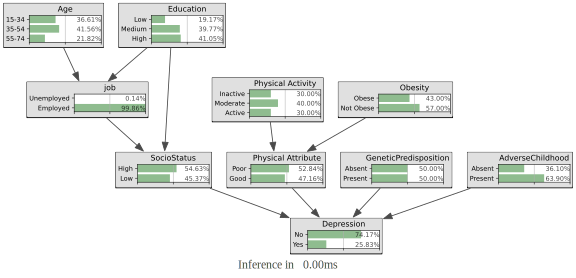

In [ ]:
ie = gum.LazyPropagation(bn)
gnb.showInference(bn)